In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

In [3]:
## SepsisDataSet.csv
df = pd.read_csv('SepsisDataSet.csv')
df.shape

(1552210, 43)

In [4]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_id', 'time'],
      dtype='object')

In [5]:
df['SepsisLabel'].value_counts()

0    1524294
1      27916
Name: SepsisLabel, dtype: int64

In [6]:
df['SepsisLabel'].value_counts(normalize=True)

0    0.982015
1    0.017985
Name: SepsisLabel, dtype: float64

In [7]:
len(df['Patient_id'].unique())

40336

In [8]:
sepsis_pat = np.array(df.groupby(['Patient_id']) \
                          ['SepsisLabel'].sum())
len(sepsis_pat[sepsis_pat > 0])

2932

In [14]:
lab=['BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate',
      'Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

vitals = ['EtCO2']

demo = ['Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS', 'Patient_id', 'time']

label = ['SepsisLabel']

In [15]:
def drop_vitals(df):
    df.drop(vitals, axis = 1, inplace = True)
   
    
def drop_lab(df):
    df.drop(lab, axis = 1, inplace = True)

def drop_demo(df):
    df.drop(demo, axis = 1, inplace = True)

In [16]:
def carry_fwd_imp(df):
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

def drop_features(df):
    drop_vitals(df)
    drop_lab(df)
    drop_demo(df)
    

def drop_ado(df):
    df.drop(df[df.Age <= 15].index, inplace=True)    
    

In [1]:
drop_ado(df)

NameError: name 'drop_ado' is not defined

In [17]:
drop_features(df)

In [18]:
mis_values = (df.isnull().sum() / df.shape[0]) * 100

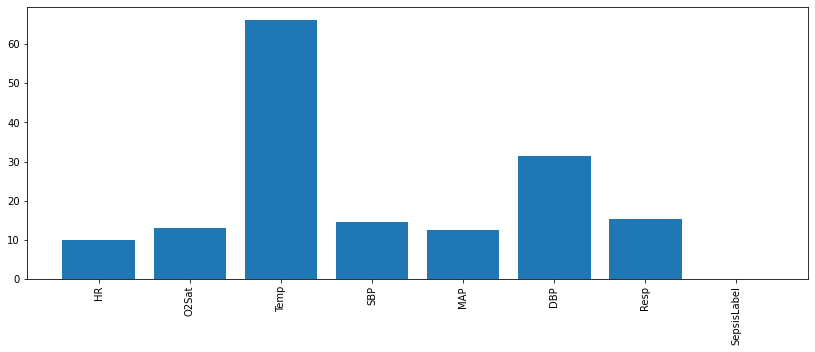

In [19]:
rcParams['figure.figsize'] = 14, 5
_ = plt.bar(mis_values.index, mis_values)
_ = plt.xticks(mis_values.index, rotation=90)

In [21]:
df.drop('DBP', axis = 1, inplace = True)

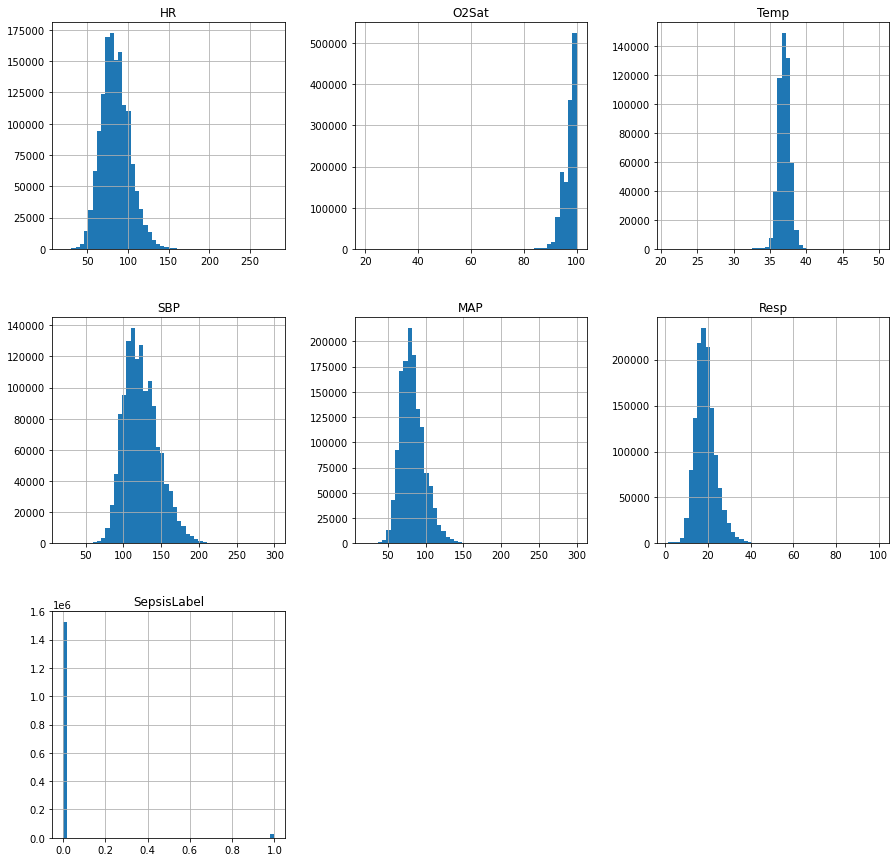

In [22]:
df.hist(figsize=(15, 15), bins=50);

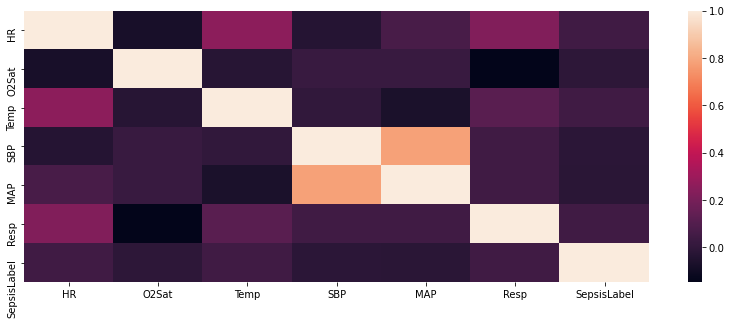

In [23]:
corr = df.corr()
sns.heatmap(corr);

In [24]:
carry_fwd_imp(df)

In [25]:
(df.isnull().sum().sort_values(ascending=False)/df.isnull().count()).sort_values(ascending=False)

Temp           0.0
SepsisLabel    0.0
SBP            0.0
Resp           0.0
O2Sat          0.0
MAP            0.0
HR             0.0
dtype: float64

In [26]:
# final selected features
df.head()

,HR,O2Sat,Temp,SBP,MAP,Resp,SepsisLabel
0,85.0,100.0,37.39,121.0,79.67,16.0,0
1,85.0,100.0,37.39,121.0,79.67,16.0,0
2,72.0,100.0,37.39,110.0,72.67,16.0,0
3,74.0,100.0,37.39,109.0,75.00,16.0,0
4,75.0,100.0,37.39,104.0,70.00,16.0,0


In [27]:
df.shape

(1552096, 7)

## Random Forest classifier
Feature importance

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [29]:
y = df['SepsisLabel']
df.drop(['SepsisLabel'], axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split( df , y , test_size=.3, random_state=40)


In [30]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train);

In [31]:
# Get numerical feature importances
feature_list = list(X_train.columns)
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: SBP                  Importance: 0.21
Variable: MAP                  Importance: 0.2
Variable: HR                   Importance: 0.18
Variable: Temp                 Importance: 0.18
Variable: Resp                 Importance: 0.13
Variable: O2Sat                Importance: 0.1


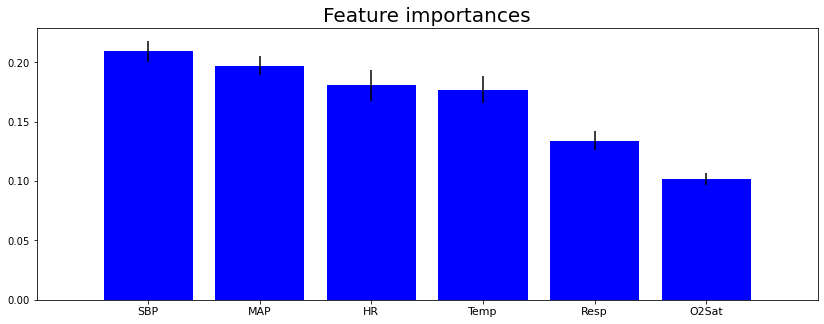

In [34]:
# Plot the feature importances of the forest
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances", size = 20)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), ['SBP','MAP','HR', 'Temp','Resp', 'O2Sat'], size = 11)
plt.xlim([-1, X_train.shape[1]])

plt.savefig('featuresRF.png')
plt.show()